# Import Libraries

In [1]:
import sys, os, re

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils import data
from torchvision import transforms

from PIL import Image
import json
import CityScapes_labels as labels


# Interface Class

In [58]:
class CityScapesInterface(data.Dataset):
    
    # constructor
    def __init__(self, img_path, gt_path, list_of_classes, label2id, id2label):
        self.img_path = img_path
        self.gt_path = gt_path
        
        self.citynames = os.listdir(self.img_path)
        self.imgs = self.load_imgs()
        self.list_of_classes = list_of_classes
        self.label2id = label2id
        self.id2label = id2label
        self.create_classes_helper()
        #self.semantic_masks = self.__get_semantic_mask()
        #self.json_files = self.__get_json_files()
        
        
    
    def create_classes_helper(self):
        self.class_to_idx = {}
        self.idx_to_class = {}
        for idz, c in enumerate(self.list_of_classes[1:]):
            assert c in self.label2id.keys()
            self.class_to_idx[self.label2id[c]] = idz + 1
            self.idx_to_class[idz+1] = self.label2id[c]
        
    # load images file names
    def load_imgs(self):
        imgs = []
        for city in self.citynames:
            city_imgs = os.listdir(os.path.join(self.img_path, city))
            imgs.extend(city_imgs)
        
        return imgs
        
    
       
    def __get_semantic_mask(self, idx):
        semantic_masks_files = []
        for img in range(len(self.imgs)):
            semantic_masks_file = self.imgs[idx].split('_')
            semantic_masks_file = semantic_masks_file[0]+'_'+semantic_masks_file[1]+'_'+semantic_masks_file[2]+'_labelIds.png'
            semantic_masks_files.append(semantic_masks_file)
            
        return semantic_masks_files
    
    
    # method to get json path
    def _get_json_path(self, idx):
        json_file = self.imgs[idx].split('_')
        city_name = json_file[0]
        json_file = json_file[0] + '_' + json_file[1] + '_' + json_file[2] + '_gtFine_polygons.json'
        json_file = os.path.join(self.gt_path, city_name, json_file)
        return json_file
    

    # method to get the semantic image path
    def _get_semantic_path(self, idx):
        json_file = self.imgs[idx].split('_')
        city_name = json_file[0]
        json_file = json_file[0] + '_' + json_file[1] + '_' + json_file[2] + '_gtFine_labelIds.png'
        json_file = os.path.join(self.gt_path, city_name, json_file)
        return json_file
    
    # method to get the instance image path
    def _get_instance_path(self, idx):
        json_file = self.imgs[idx].split('_')
        city_name = json_file[0]
        json_file = json_file[0] + '_' + json_file[1] + '_' + json_file[2] + '_gtFine_instanceIds.png'
        json_file = os.path.join(self.gt_path, city_name, json_file)
        return json_file

    
    # Get Bounding boxes
    def bounding_boxes(self, idx):
        file_name = self._get_json_path(idx)
        bbox_json = open(file_name)
        data = json.load(bbox_json)
        objects = data['objects']
        list_of_objects = []
        bboxes = []
        for obj in objects:
            #print(obj)
            if obj['label'] in self.list_of_classes[1:]:
                #print(obj)
                list_of_objects.append(self.label2id[obj['label']])
                x,y = zip(*obj['polygon'])
                min_x, max_x = min(x), max(x)
                min_y, max_y = min(y), max(y)
                bbox = [min_x, min_y, max_x, max_y]         
                bboxes.append(bbox)

        label = {}
        classes = torch.tensor(list_of_objects, dtype=torch.int64)
        label['classes'] = classes
        label['bboxes'] = torch.tensor(bboxes, dtype=torch.float32)

        return label
    
    # get semantic segmantation mask
    def semantic_mask(self, idx):
        file_name = self._get_semantic_path(idx)
        mask = np.array(Image.open(file_name))
        unique_values = np.unique(mask)
        for label in unique_values:
            _l = self.id2label[label]

            if not _l in self.list_of_classes:
                mask[mask==label]=0

        unique_values = np.unique(mask)
        for value in unique_values[1:]:
            mask[mask==value] = self.class_to_idx[value]

        mask = torch.tensor(mask, dtype=torch.uint8) 
        return mask
    
    
    # method to get instance segmantation mask
    def instance_masks(self, idx):
        file_name_instance = self._get_instance_path(idx)
        mask = torch.tensor(np.array(Image.open(file_name_instance)), dtype=torch.uint8)

        _mask_segmentation = self.semantic_mask(idx)
        #plt.imshow(_mask_segmentation)

        dict_values = dict()
        _instance_mask = mask*_mask_segmentation
        for ins in np.unique(_mask_segmentation)[1:]:
            y = _mask_segmentation.clone()
            y[y!=ins] = 0
            _mask = mask*y
            for pixel in np.unique(_mask)[1:]:
                dict_values[pixel] = ins
            #print(len(segmented_masks_list))
            #print(ins, ' ', list_of_classes[ins])

        _instances = np.unique(_instance_mask)
        list_of_masks = []
        for _m in _instances[1:]:
            _mask = torch.zeros(mask.shape, dtype = torch.uint8)
            #print(_m, ' ',list_of_classes[dict_values[_m]])
            _mask[_instance_mask == _m] = dict_values[_m]
            #plt.imshow(_mask)
            #plt.show()    
            list_of_masks.append(_mask)
    
        return list_of_masks
    
    
    # method to return bounding boxes and instance masks
    def extract_bounding_boxes_and_masks(self, idx):
        instance_mask_file = self._get_instance_path(idx)
        #semantic_mask_file = self._get_semantic_path(idx)
        #annotation_file_name = self._get_json_path(idx)
        
        instance_mask = np.array(Image.open(instance_mask_file), dtype=np.uint8)
        semantic_mask_img = self.semantic_mask(idx)
        
        final_mask = semantic_mask_img*instance_mask
    
        label = self.bounding_boxes(idx)
        
        bboxes = label['bboxes']
        classes = label['classes']
        masks = []
        
        for idx in range(len(bboxes)):
            bbox = bboxes[idx]
            bbox = [int(x) for x in bbox]
            aux_array = np.zeros([final_mask.shape[0], final_mask.shape[1]])
            crop = final_mask[bbox[1]:bbox[3], bbox[0]:bbox[2]]
            '''
            v = crop[int(crop.shape[0]/2)][int(crop.shape[1]/2)]
            if v != 0:
                crop[crop != v] = 0
            '''
            aux_array[bbox[1]:bbox[3], bbox[0]:bbox[2]] = crop
            #aux_array[aux_array != unique_values[idx_unique_value]] = 0
            #mask = aux_array[aux_array == unique_values[idx_unique_value]]
            aux_array = torch.tensor(aux_array, dtype=torch.uint8)
            masks.append(aux_array)
    
        label['masks'] = masks
        return label
        
    
    
    # return the number of images
    def __len__(self):
        return len(self.imgs)
    
    # get item
    def __getitem(self, idx):
        pass

In [59]:
img_path = '../../Datasets/cityscapes/leftImg8bit/train'
gt_path = '../../Datasets/cityscapes/gtFine/train'
list_of_classes = ['__bgr__', 'car', 'person']

In [60]:
interface = CityScapesInterface(img_path, gt_path, list_of_classes, labels.label2id, labels.id2label)

In [63]:
label = interface.extract_bounding_boxes_and_masks(50)

In [65]:
interface.imgs[50]

'aachen_000050_000019_leftImg8bit.png'

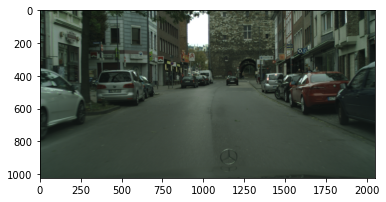

In [67]:
img = Image.open(os.path.join(img_path, 'aachen/'+interface.imgs[50]))
plt.imshow(img)
plt.show()

person


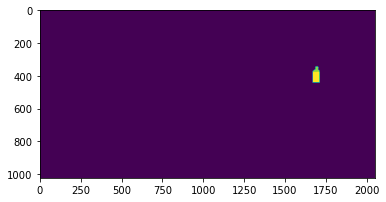

person


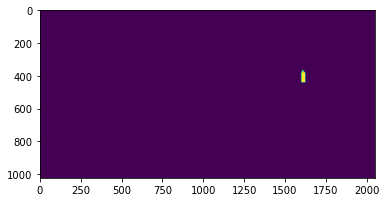

person


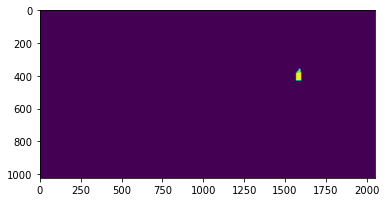

person


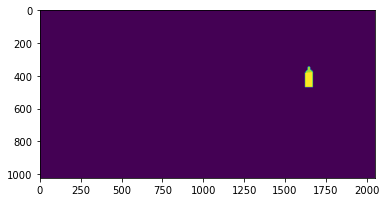

car


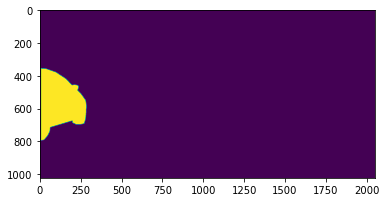

car


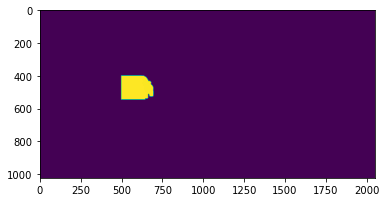

car


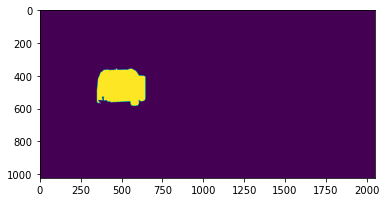

car


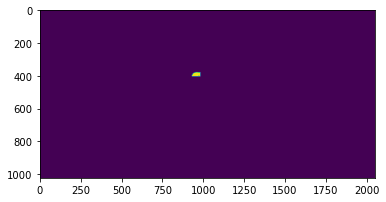

car


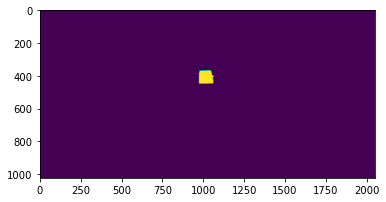

car


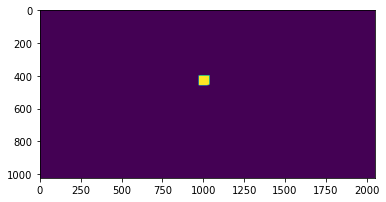

car


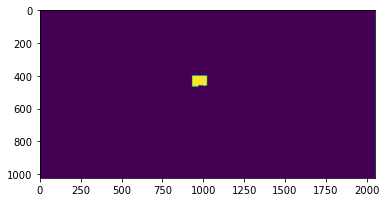

person


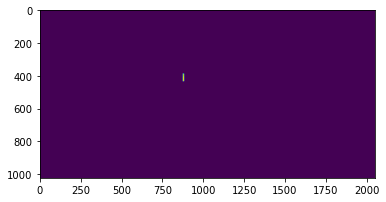

person


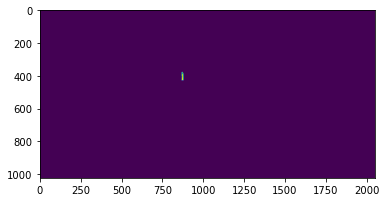

car


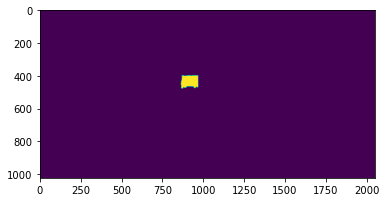

person


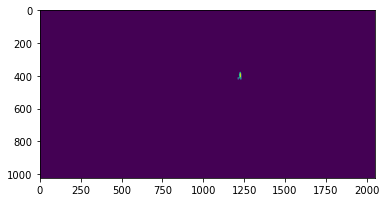

person


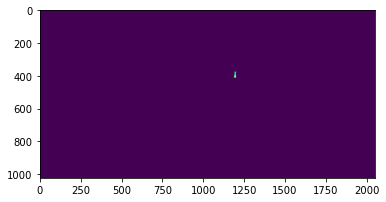

person


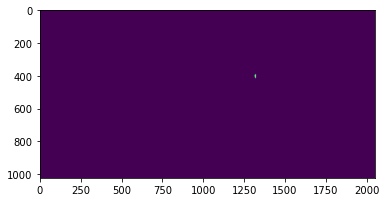

person


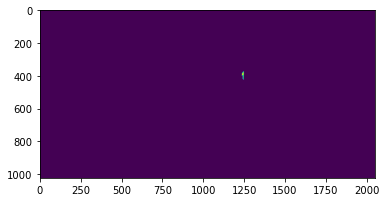

car


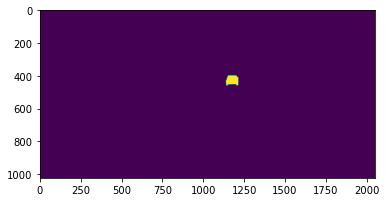

person


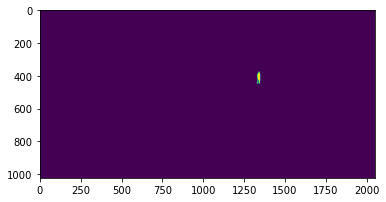

car


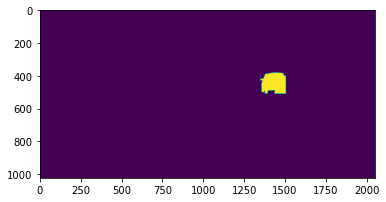

car


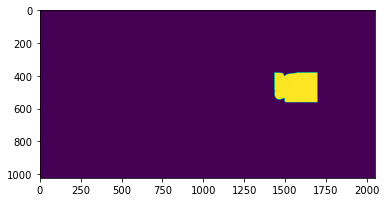

car


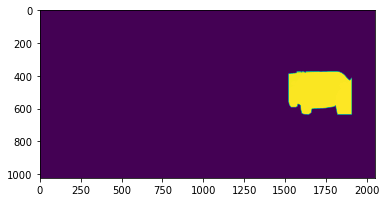

car


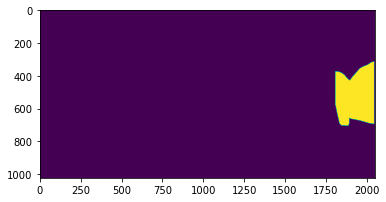

In [68]:
for idx in range(len(label['masks'])):
    print(interface.id2label[label['classes'][idx].item()])
    #print(label['classes'][idx].item())
    plt.imshow(label['masks'][idx])
    plt.show()